In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [12]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'autoincrement': 'auto',
  'primary_key': 0}]

# Exploratory Climate Analysis

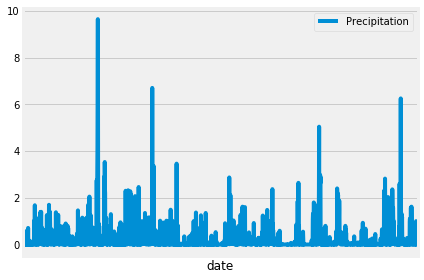

In [13]:
# Choose start and end vacation dates
begin_date = dt.datetime(2017, 5, 1)
end_date = dt.datetime(2017, 5, 15)

# Design a query to retrieve the last 12 months of precipitation data and plot the results
sel = [Measurement.prcp, Measurement.date]

last_year_prcp = session.query(*sel).\
    filter(Measurement.date >= end_date - dt.timedelta(days=365)).\
    filter(Measurement.date <= end_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(last_year_prcp, columns = ['prcp', 'date'])
prcpDF.set_index('date', inplace=True)

# Sort the dataframe by date
prcpDF.sort_index(ascending=True, inplace=True)

# Drop rows without precipitation data
prcpDF.dropna(how='any',axis=0,inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
prcpDF.plot()
plt.xticks([])
plt.legend(['Precipitation'])
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcpDF.describe()

,prcp
count,2059.000000
mean,0.216897
std,0.572708
min,0.000000
25%,0.000000
50%,0.020000
75%,0.160000
max,9.640000


In [15]:
# Design a query to show how many stations are available in this dataset?

sel = [func.count(Station.name)]

stationsCount = session.query(*sel).all()[0][0]

stationsCount

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel = [Measurement.station, func.count(Measurement.date)]

stationObservations = session.query(*sel).\
                      group_by(Measurement.station).\
                      order_by(func.count(Measurement.date).desc()).all()

stationObservations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

highObsStation = stationObservations[0][0]

sel = [
        Measurement.station, func.min(Measurement.tobs),
        func.max(Measurement.tobs), func.avg(Measurement.tobs)
      ]

activeStats = session.query(*sel).\
              filter(Measurement.station == highObsStation).all()

activeStats

print(f'The station with the most observations has a station id of: {activeStats[0][0]}')
print(f'The lowest temperature recorded at that station was {activeStats[0][1]} degrees.')
print(f'The highest temperature recorded at that station was {activeStats[0][2]} degrees.')
print(f'The average temperature recorded at that station was {activeStats[0][3]} degrees.')


The station with the most observations has a station id of: USC00519281
The lowest temperature recorded at that station was 54.0 degrees.
The highest temperature recorded at that station was 85.0 degrees.
The average temperature recorded at that station was 71.66378066378067 degrees.


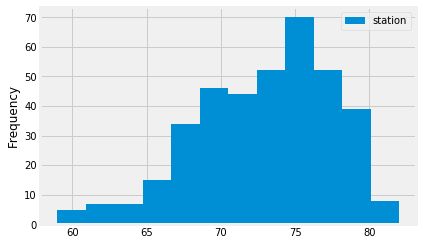

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [Measurement.station, Measurement.tobs, Measurement.date]

stationTobs = session.query(*sel).\
              filter(Measurement.date >= begin_date - dt.timedelta(days=365)).\
              filter(Measurement.date <= end_date).\
              filter(Measurement.station == highObsStation).all()

topStationDF = pd.DataFrame(stationTobs, columns = ['tobs', 'station', 'date'])
topStationDF.set_index('date', inplace=True)
topStationDF.plot.hist(bins=12)
plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(begin, end):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        begin (string): A date string in the format %Y-%m-%d
        end (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= begin).filter(Measurement.date <= end).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [42]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_begin = begin_date - dt.timedelta(days=365)
temp_end = end_date - dt.timedelta(days=365)

print(
    'Temperature stats from ' + str(dt.datetime.strftime(begin_date, "%Y-%m-%d")) + ' to '
    + str(dt.datetime.strftime(end_date, "%Y-%m-%d")) + ':'
    + '\nMinimum: ' + str(round(calc_temps(temp_begin, temp_end)[0][0], 2)) 
    + '\nAverage: ' + str(round(calc_temps(temp_begin, temp_end)[0][1], 2)) 
    + '\nMaximum: ' + str(round(calc_temps(temp_begin, temp_end)[0][2], 2))
     )

Temperature stats from 2017-05-01 to 2017-05-15:
Minimum: 65.0
Average: 72.9
Maximum: 79.0
